## Introduction

This is a study of flight take off data from John F. Kennedy International Airport. 
Our goal is to predict the taxi-out time of a flight.   

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from pathlib import Path

sns.set_theme(style="darkgrid")
%matplotlib inline

SEED = 111

## GET DATA

In [ ]:
file_name = "M1_final.csv"
folder_name = "./"
location = Path(folder_name, file_name)

df = pd.read_csv(location)
df

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,DEST,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_M,DEP_TIME_M,CRS_ARR_M,Temperature,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Condition,sch_dep,sch_arr,TAXI_OUT
0,11,1,5,B6,N828JB,CHS,-1,124,636,324,323,448,48,34,58,W,25,38,29.86,Fair / Windy,9,17,14
1,11,1,5,B6,N992JB,LAX,-7,371,2475,340,333,531,48,34,58,W,25,38,29.86,Fair / Windy,9,17,15
2,11,1,5,B6,N959JB,FLL,40,181,1069,301,341,482,48,34,58,W,25,38,29.86,Fair / Windy,9,17,22
3,11,1,5,B6,N999JQ,MCO,-2,168,944,345,343,513,48,34,58,W,25,38,29.86,Fair / Windy,9,17,12
4,11,1,5,DL,N880DN,ATL,-4,139,760,360,356,499,46,32,58,W,24,35,29.91,Fair / Windy,9,17,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28815,1,31,5,B6,N216JB,ORH,2,57,150,1370,1372,1427,39,38,96,N,6,0,30.18,Cloudy,20,32,19
28816,1,31,5,AA,N104NN,BOS,2,75,187,1390,1392,25,39,38,96,N,6,0,30.18,Cloudy,19,23,22
28817,1,31,5,AS,N581AS,SEA,283,392,2422,1125,1408,1337,39,38,96,N,6,0,30.18,Cloudy,19,23,21
28818,1,31,5,B6,N957JB,SJU,5,224,1598,1417,1422,261,39,38,96,N,6,0,30.18,Cloudy,19,23,13


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28820 entries, 0 to 28819
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MONTH              28820 non-null  int64  
 1   DAY_OF_MONTH       28820 non-null  int64  
 2   DAY_OF_WEEK        28820 non-null  int64  
 3   OP_UNIQUE_CARRIER  28820 non-null  object 
 4   TAIL_NUM           28820 non-null  object 
 5   DEST               28820 non-null  object 
 6   DEP_DELAY          28820 non-null  int64  
 7   CRS_ELAPSED_TIME   28820 non-null  int64  
 8   DISTANCE           28820 non-null  int64  
 9   CRS_DEP_M          28820 non-null  int64  
 10  DEP_TIME_M         28820 non-null  int64  
 11  CRS_ARR_M          28820 non-null  int64  
 12  Temperature        28820 non-null  int64  
 13  Dew Point          28820 non-null  object 
 14  Humidity           28820 non-null  int64  
 15  Wind               28818 non-null  object 
 16  Wind Speed         288

### Description of the columns

There are $28820$ observations of $23$ variables.
Each observation is an individual flight.
- `MONTH`, `DAY_OF_MONTH`, `DAY_OF_WEEK` contain information about the date of the flight
- `OP_UNIQUE_CARRIER` contains ID of the airline (i.e. `AA` stands for American Airlines)
- `TAIL_NUM` is the tail number of the plane
- `DEST` is the destination airport code
- `DEP_DELAY` is the departure delay of the flight
- `CRS_ELAPSED_TIME` is expected duration of the light
- `DISTANCE` is the distance between airports
- `CRS_DEP_M` is scheduled departure time (in minutes after midnight)
- `DEP_TIME_M` is actual departure time (gate checkout)
- `CRS_ARR_M` is scheduled arrival time
- `Temperature`, `Dew Point`, `Humidity`, `Wind Speed`, `Wind Gust` and `Pressure` are the numeric characteristis of the weather
- `Wind` is the direction of the wind (`CALM` if calm, `VAR` if wind blows from various directions)
- `Condition` contains natural language description of the weather
- `sch_dep` is the number of flights scheduled for departure
- `sch_arr` is the number of flights scheduled for arrival 
- `TAXI_OUT` is the time between the actual pushback and wheels-off.

There are five caterogical variables: `OP_UNIQUE_CARRIER`, `TAIL_NUM`, `DEST`, `WIND` and `Condition`. 
The rest of the variables is numerical.

## DATA CLEANING

In [ ]:
TARGET = "TAXI_OUT"

In [ ]:
# change wind into degrees
wind_directions = {'NNW': 340, 'CALM': 0, 'NNE':20, 'NE':45, 'VAR':0, 'WSW':230, 'S':180, 'SSW':200, 'WNW':290, 'ESE':115, 'N': 360, 'SW':225, 'E':90, 'W':270, 'SSE':155, 'ENE':70, 'NW':315, 'SE':135}


for item in wind_directions:
    df.loc[df['Wind'] == item, "Wind"] = wind_directions[item]


### Checking for null Values

Replacing infinite values, if any


In [ ]:
df = df.replace([np.inf, -np.inf], np.nan)

In [ ]:
df.isnull().sum().sort_values(ascending=False)

Wind                 2
TAXI_OUT             0
DEP_TIME_M           0
DAY_OF_MONTH         0
DAY_OF_WEEK          0
OP_UNIQUE_CARRIER    0
TAIL_NUM             0
DEST                 0
DEP_DELAY            0
CRS_ELAPSED_TIME     0
DISTANCE             0
CRS_DEP_M            0
CRS_ARR_M            0
sch_arr              0
Temperature          0
Dew Point            0
Humidity             0
Wind Speed           0
Wind Gust            0
Pressure             0
Condition            0
sch_dep              0
MONTH                0
dtype: int64

Hence, there are 2 null values in the wind column. Given the size of the datset, we can safely drop the 2 rows.

In [ ]:
# drop null rows
df = df.dropna()

In [ ]:
df['Dew Point'] = df['Dew Point'].astype('int')
df['Wind'] = df['Wind'].astype('int')

### Randomize Data
For later sampling

In [ ]:
df = df.sample(frac=1, random_state=SEED)

In [ ]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

## Exploratory Data Analysis

### Univariate Analysis

In [ ]:
desc = df.describe(include = [np.number])
desc.loc['IQR'] = desc.loc['75%']-desc.loc['25%']
desc.loc['Median'] = desc.loc['50%']
mode = []

numeric_cols = df.select_dtypes(include='number')
attributes = list(numeric_cols.columns.values)

for i in attributes:
    mode.append(stats.mode(df[i])[0][0])
desc.loc['Mode'] = mode
range_ = []
for i in attributes:
    range_.append(str(df[i].min())+" - "+str(df[i].max()))
desc.loc['Range'] = range_
desc

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_M,DEP_TIME_M,CRS_ARR_M,Temperature,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,sch_dep,sch_arr,TAXI_OUT
count,28818,28818,28818,28818,28818,28818,28818,28818,28818,28818,28818,28818,28818,28818,28818,28818,28818,28818,28818
mean,7.89396,16.0209,4.00895,6.37324,225.294,1267.79,830.97,828.899,910.887,41.491,30.4222,57.7328,223.582,12.3685,5.53571,30.0924,31.092,28.4318,20.8572
std,4.99178,8.75045,1.9853,38.7352,119.483,889.354,299.382,305.845,345.371,8.04249,12.3133,23.4695,106.392,6.25867,11.8868,0.296158,9.51032,8.26324,6.8502
min,1,1,1,-22,57,94,301,1,1,17,-3,0,0,0,0,29.2,0,0,5
25%,1,8,2,-6,124,483,545,542,667,36,23,46,180,8,0,29.88,26,21,16
50%,11,16,4,-3,188,1029,856,854,918,42,31,59,230,12,0,30.11,30,30,19
75%,12,24,6,2,365,2248,1095,1097,1192.75,47,39,74,315,16,0,30.32,37,35,25
max,12,31,7,1276,697,4983,1439,1440,1439,68,67,97,360,36,49,30.75,55,46,41
IQR,11,16,4,8,241,1765,550,555,525.75,11,16,28,135,8,0,0.44,11,14,9
Median,11,16,4,-3,188,1029,856,854,918,42,31,59,230,12,0,30.11,30,30,19


Categorical Features

In [ ]:
df.describe(include=['O'])

,OP_UNIQUE_CARRIER,TAIL_NUM,DEST,Condition
count,28818,28818,28818,28818
unique,9,2092,65,25
top,B6,N102NN,LAX,Mostly Cloudy
freq,9588,108,2974,9122


There are no anomalies in the data as all the feature data are within the correct range of values.

### Plotting the distributions

We're going to plot the distribution of each variable.
Let's start with the numerical ones.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_num_var_dist(var, kde=True, kde_plot=False, discrete=False):
  if kde_plot:
    sns.kdeplot(data=X, x=var)
  else:
    sns.histplot(data=X, x=var, kde=kde, discrete=discrete)

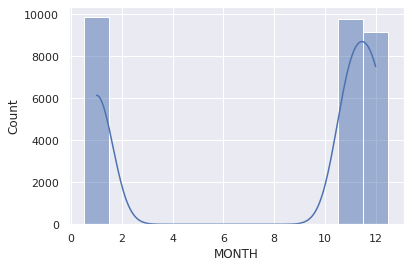

In [ ]:
plot_num_var_dist("MONTH", discrete=True)

We have data about departures from November, December, and January, distributed almost evenly.

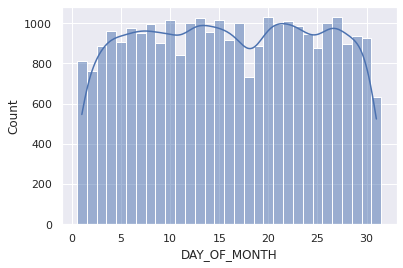

In [ ]:
plot_num_var_dist("DAY_OF_MONTH", discrete=True)

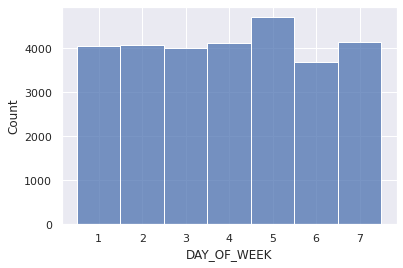

In [ ]:
plot_num_var_dist("DAY_OF_WEEK", kde=False, discrete=True)

There is equal number of flights on Monday, Tuesday, Wednesday, Thursday and Sunday (about 3200).
There are more flights on Friday (about 3600) and fewer on Saturday (about 2800).

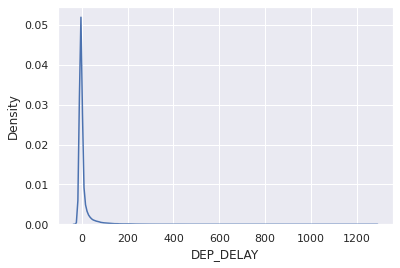

In [ ]:
plot_num_var_dist("DEP_DELAY", kde_plot=True)

As can be excpected, there is a spike around $0$.

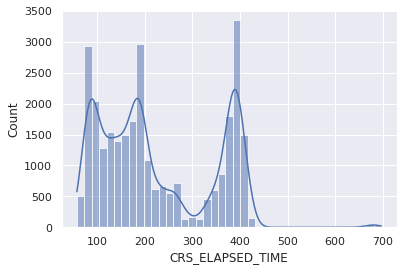

In [ ]:
plot_num_var_dist("CRS_ELAPSED_TIME")

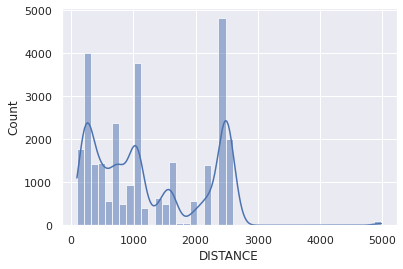

In [ ]:
plot_num_var_dist("DISTANCE")

Notice that the distributon of `DISTANCE` and `CRS_ELAPSED_TIME` is very roughly the same.

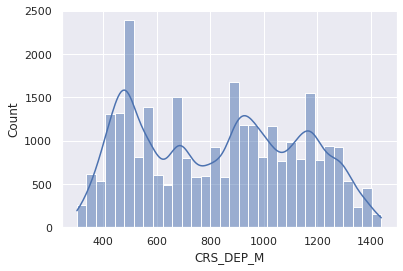

In [ ]:
plot_num_var_dist("CRS_DEP_M")

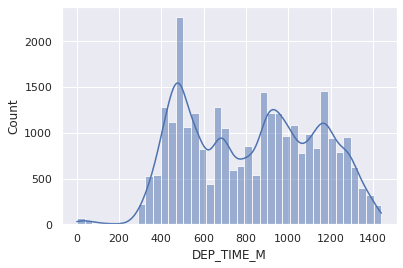

In [ ]:
plot_num_var_dist("DEP_TIME_M")

These are also pretty similar. 

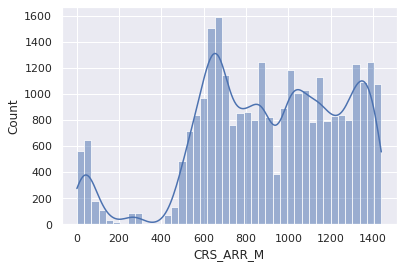

In [ ]:
plot_num_var_dist("CRS_ARR_M")

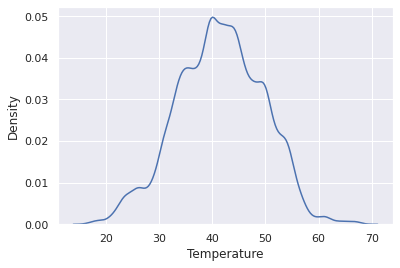

In [ ]:
plot_num_var_dist("Temperature", kde_plot=True)

This looks more or less like a normal distribution.

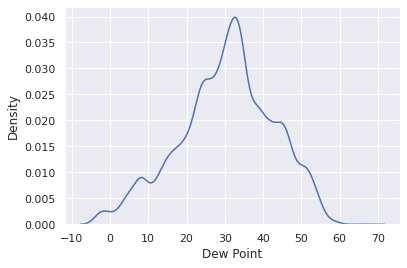

In [ ]:
X = X.astype({"Dew Point": "int"})

plot_num_var_dist("Dew Point", kde_plot=True)

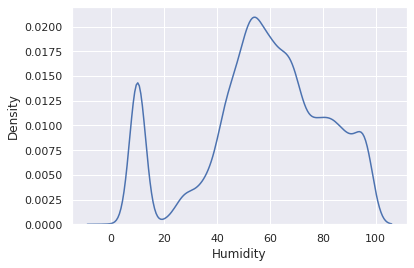

In [ ]:
plot_num_var_dist("Humidity", kde_plot=True)

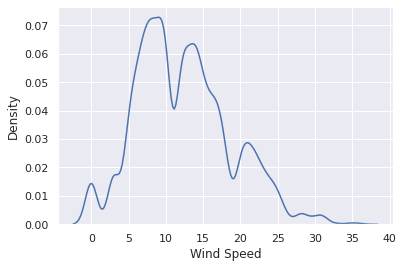

In [ ]:
plot_num_var_dist("Wind Speed", kde_plot=True)

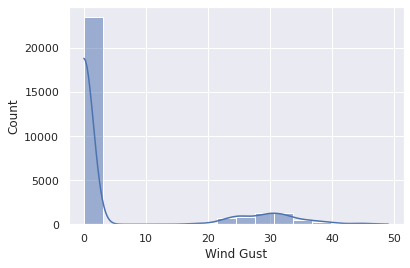

In [ ]:
plot_num_var_dist("Wind Gust")

This is another variable with a spike at $0$.

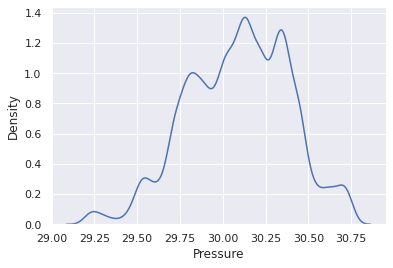

In [ ]:
plot_num_var_dist("Pressure", kde_plot=True)

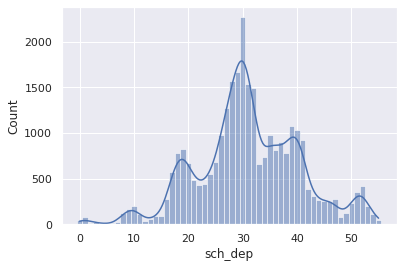

In [ ]:
plot_num_var_dist("sch_dep", discrete=True)

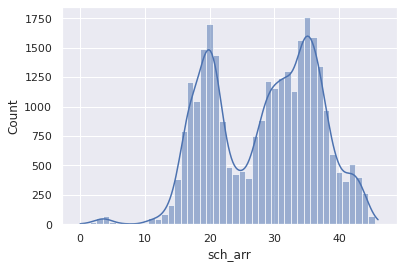

In [ ]:
plot_num_var_dist("sch_arr", discrete=True)

Now, let's create countplots for categorical variables.

In [ ]:
def plot_cat_var_dist(var, n=20, figsize=(10,5)):
  plt.figure(figsize=figsize)
  sns.countplot(y=X[var], order=X[var].value_counts().iloc[:n].index, palette="crest")

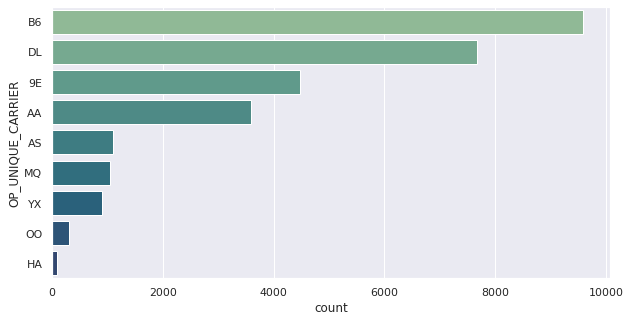

In [ ]:
plot_cat_var_dist("OP_UNIQUE_CARRIER")

There is a lot of unique values in `TAIL_NUM` column, so we can't really create a column for each one.
Instead, let's consider twenty most common tail numbers.

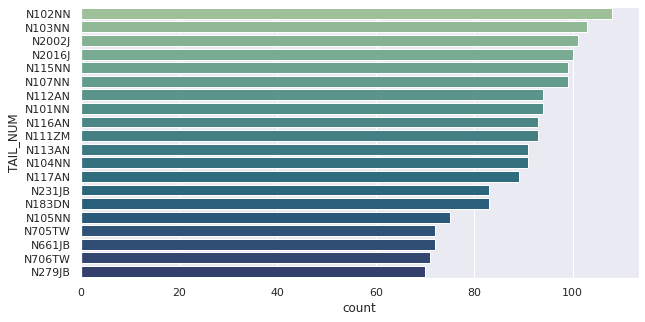

In [ ]:
plot_cat_var_dist("TAIL_NUM", n=20)

Below, we plot twenty most common arrival destinations.

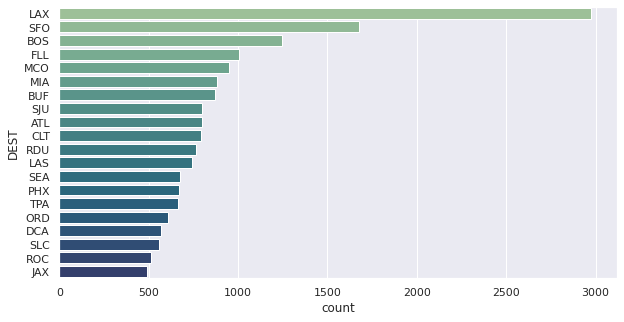

In [ ]:
plot_cat_var_dist("DEST", n=20)

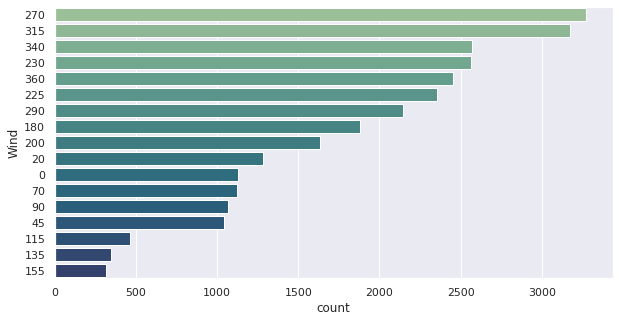

In [ ]:
plot_cat_var_dist("Wind")

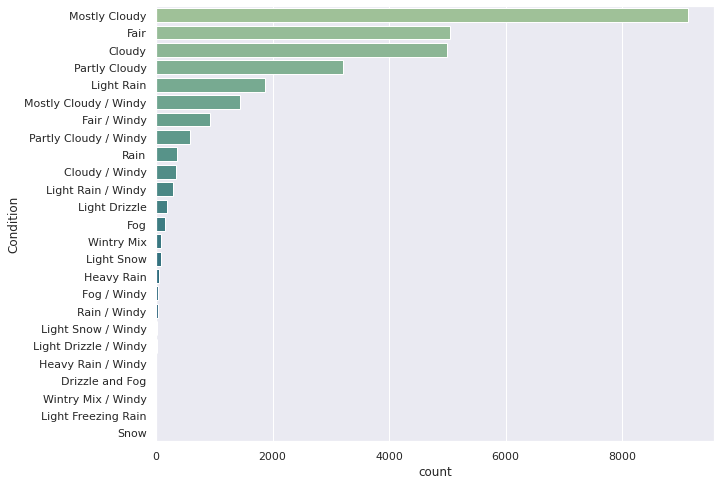

In [ ]:
plot_cat_var_dist("Condition", n=25, figsize=(10,8))

Finally, let's plot the target variable.

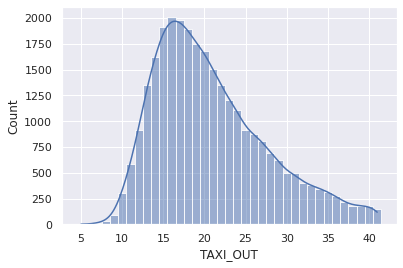

In [ ]:
sns.histplot(x=y, kde=True, discrete=True);

### Violin plots

Let's create a violin plot for each categorical variable.
Most of them have too many unique values, so we're going to consider only the most common ones.

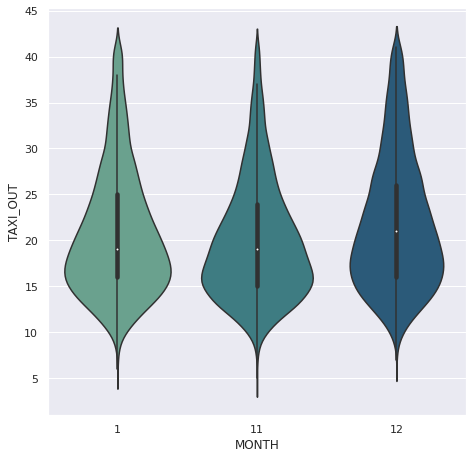

In [ ]:
import numpy as np

def violin(var, figsize=(10,10), n=10):
  mask = np.in1d(X[var], X[var].value_counts().iloc[:n].index)
  plt.figure(figsize=figsize)
  sns.violinplot(data=X.loc[mask], x=var, y=y, palette="crest")

violin("MONTH", figsize=(7.5,7.5))

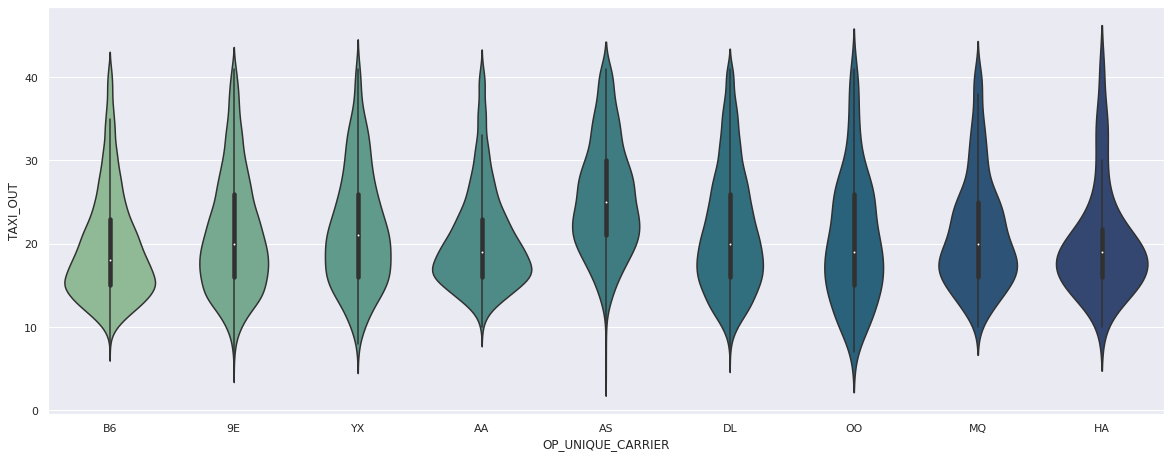

In [ ]:
violin("OP_UNIQUE_CARRIER", figsize=(20,7.5))

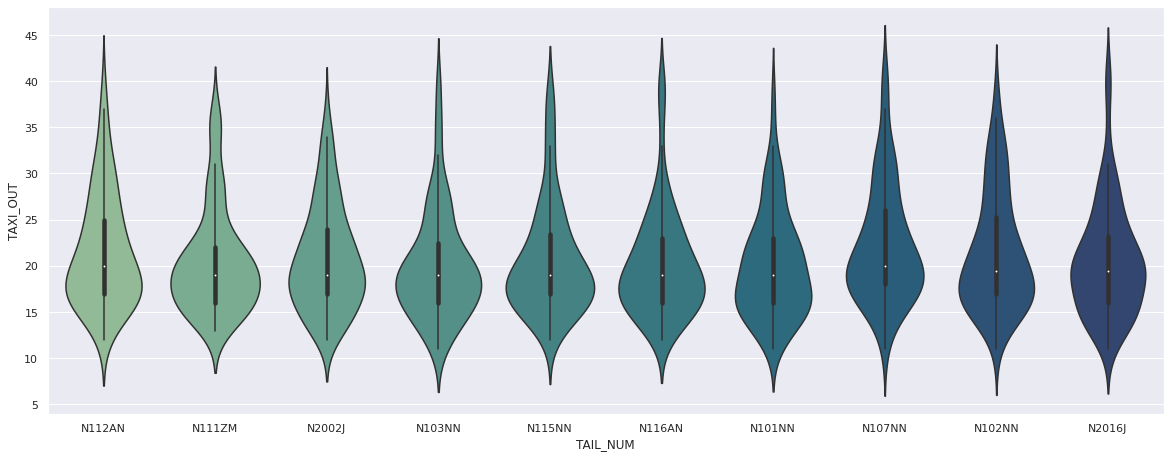

In [ ]:
violin("TAIL_NUM",  figsize=(20,7.5), n=10)

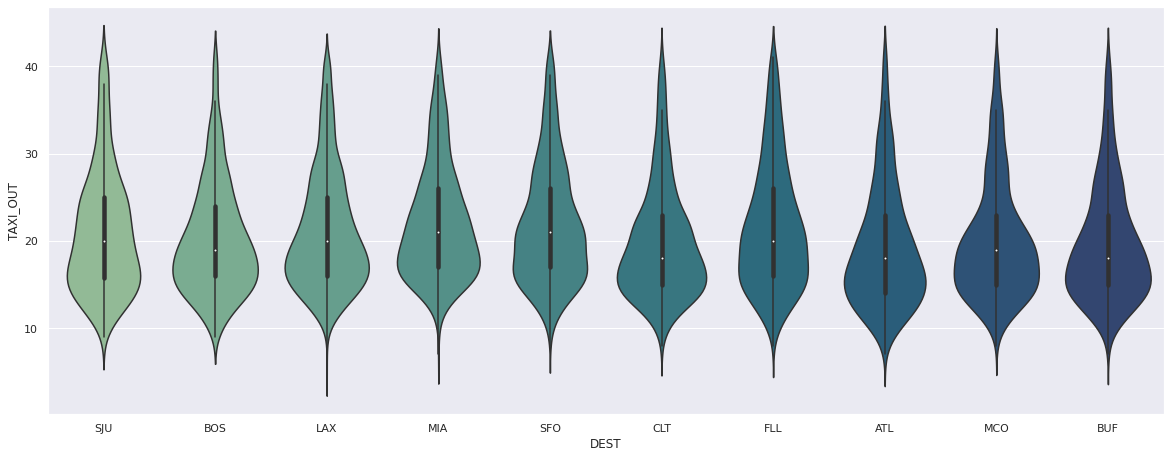

In [ ]:
violin("DEST", figsize=(20,7.5), n=10)

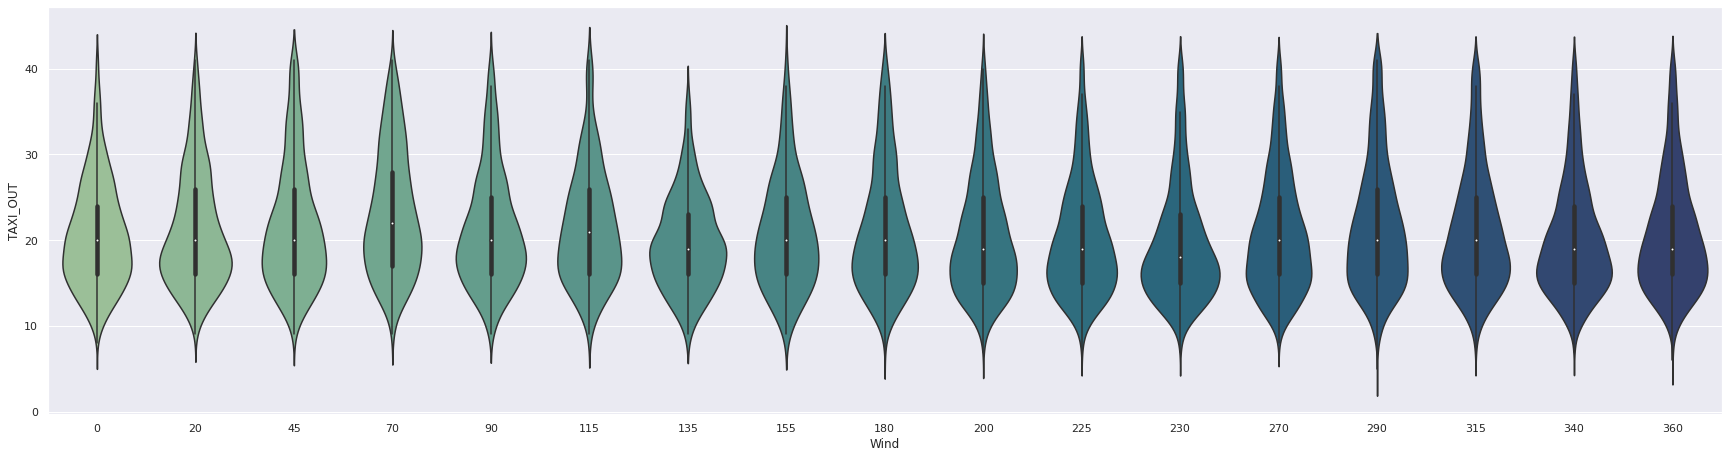

In [ ]:
violin("Wind", figsize=(30,7.5), n=20)

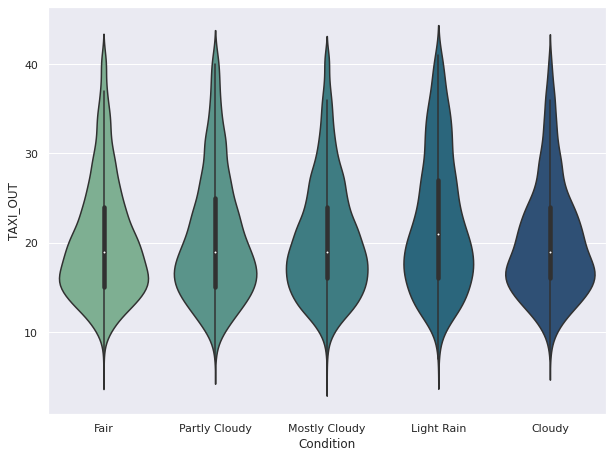

In [ ]:
violin("Condition", figsize=(10,7.5), n=5)

On the 2D plot we see two clusters, that almost could be separated by a plane.
There is also a line pattern of outliers on the right side of the plot.

### Plotting the target variable

We're going to plot the target variable against every other numerical variable on a scatterplot.

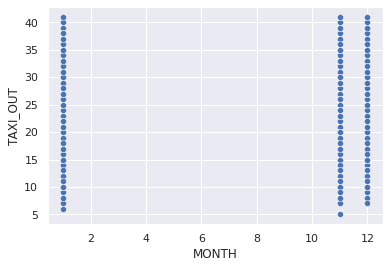

In [ ]:
def scatter(var):
  sns.scatterplot(y=y, x=X[var])

scatter("MONTH")

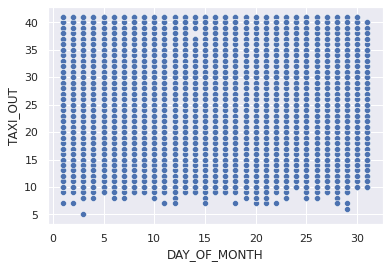

In [ ]:
scatter("DAY_OF_MONTH")

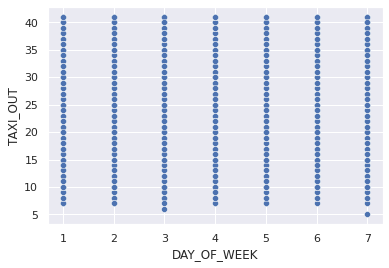

In [ ]:
scatter("DAY_OF_WEEK")

The distributions above are pretyy even.

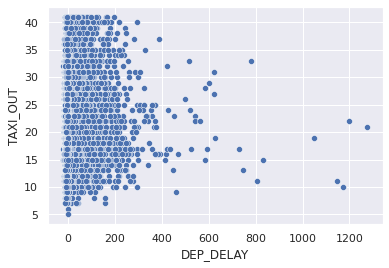

In [ ]:
scatter("DEP_DELAY")

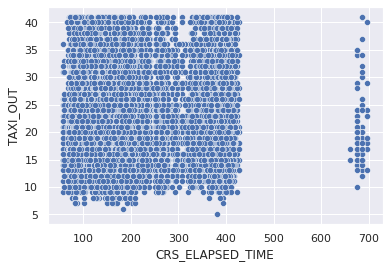

In [ ]:
scatter("CRS_ELAPSED_TIME")

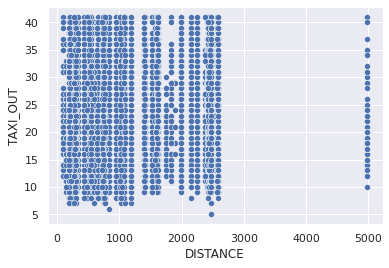

In [ ]:
scatter("DISTANCE")

Here, we see a bunch of outliers, but the target variable's values doesn't seem to be affected by them.

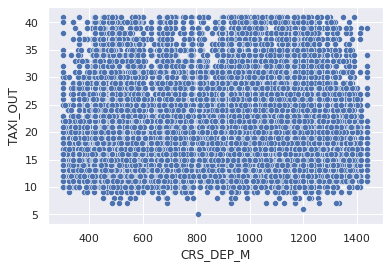

In [ ]:
scatter("CRS_DEP_M")

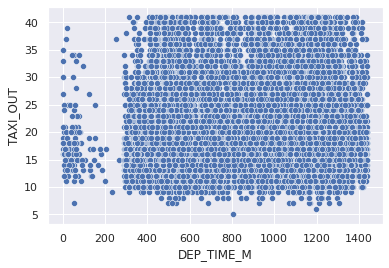

In [ ]:
scatter("DEP_TIME_M")

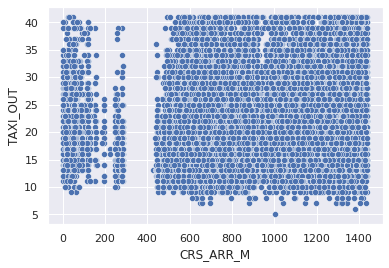

In [ ]:
scatter("CRS_ARR_M")

Here, wee see two clusters: a big one, and a smaller one.

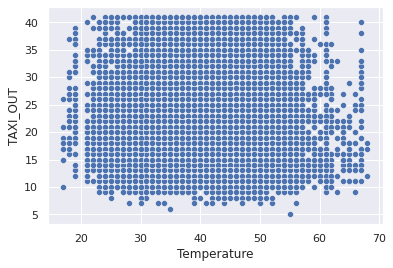

In [ ]:
scatter("Temperature")

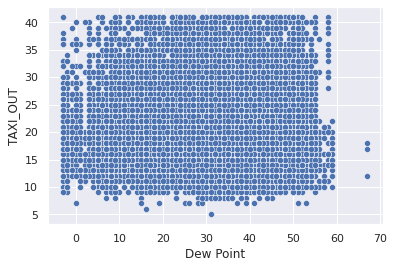

In [ ]:
scatter("Dew Point")

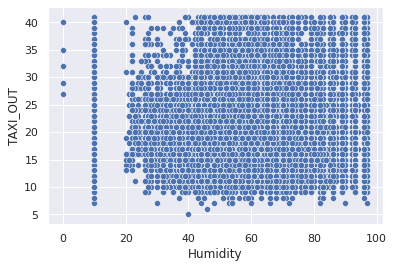

In [ ]:
scatter("Humidity")

The line on the left seems very bizzare, as if the measurement was incorrect a couple of times.

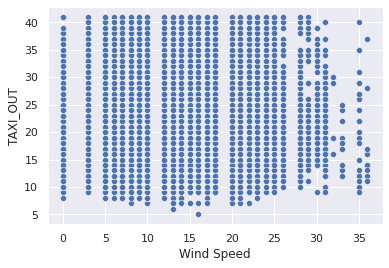

In [ ]:
scatter("Wind Speed")

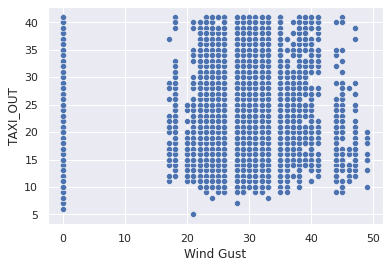

In [ ]:
scatter("Wind Gust")

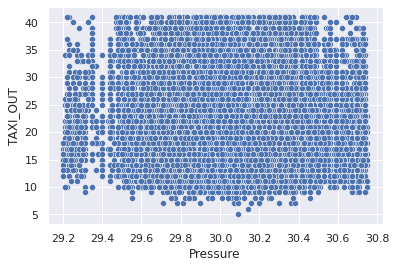

In [ ]:
scatter("Pressure")

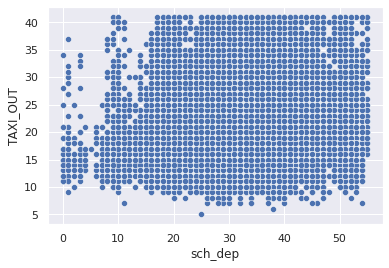

In [ ]:
scatter("sch_dep")

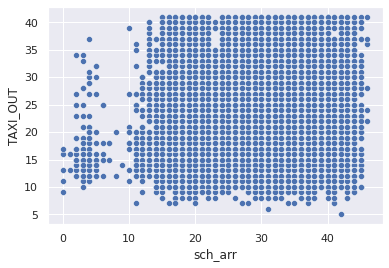

In [ ]:
scatter("sch_arr")

Again, we see traces of the second, smaller cluster.

### Correlation heatmap

Below, we see a correlation heatmap of numerical features.

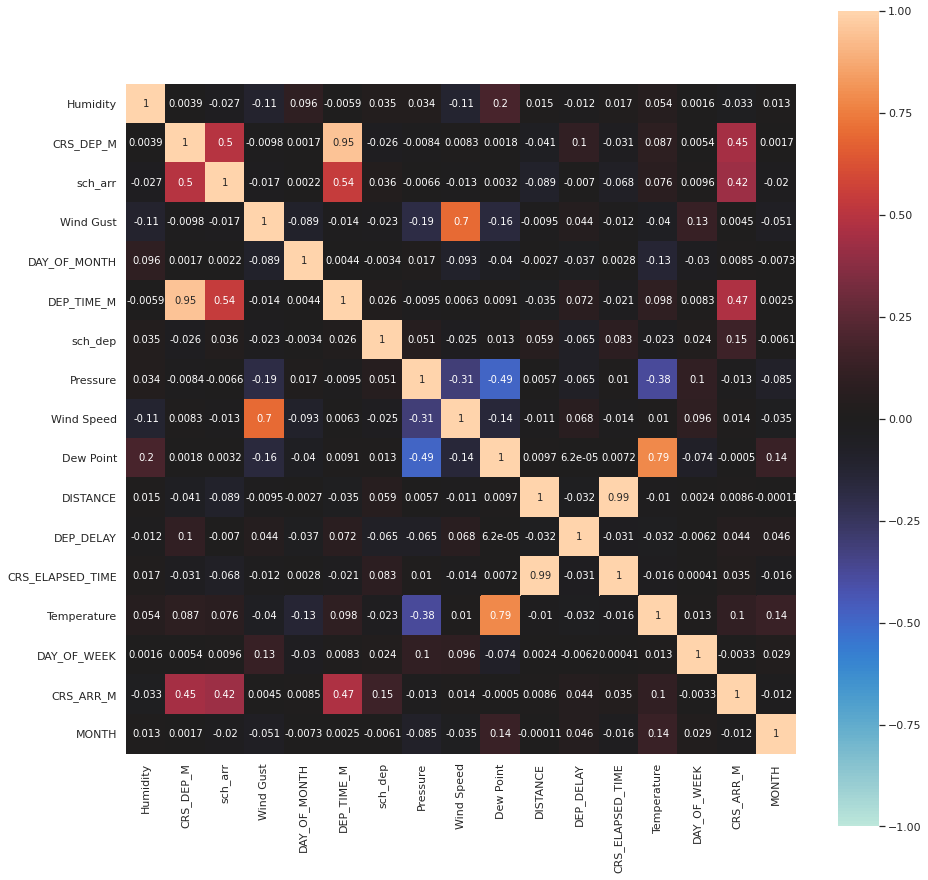

In [ ]:
categorical = ["OP_UNIQUE_CARRIER", "TAIL_NUM", "DEST", "Wind", "Condition"]
numerical = list(set(X.columns) - set(categorical))
corr = X[numerical].corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr, vmin=-1, vmax=1, center=0, square=True, annot=True);

There are two pairs of highly correlated features:
- `DISTANCE` and `CRS_ELAPSED_TIME`: this is pretty obvious (the more distant the destination the longer the journey is going to take) and we noticed it before. I believe we can safely remove `DISTANCE` column.
- `CRS_DEP_M` and `DEP_TIME_M`: this is also not surprising, first column contains scheduled departure time, the other the actual deprature time. Their difference is containted in the `DEP_DELAY` variable, so here we also most likely can remove one of the features.

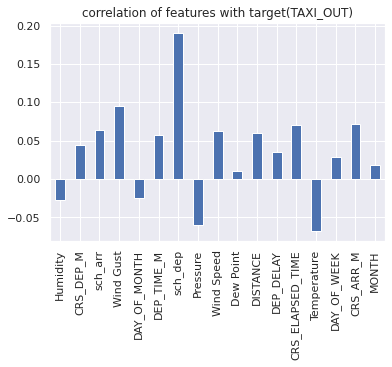

In [ ]:
X[numerical].corrwith(y).plot(kind = 'bar', title = 'correlation of features with target(TAXI_OUT)')

In [ ]:
df.drop(["DISTANCE", "CRS_DEP_M"], axis=1, inplace=True)

As Tail number of a flight doesn't influnce the target attribute, we can drop it

In [ ]:
df.drop("TAIL_NUM", axis=1, inplace=True)

One Hot Encoding

In [ ]:
X_OE = pd.get_dummies(X, columns=['OP_UNIQUE_CARRIER', 'DEST', 'Condition'])

X_OE.shape

(28818, 118)

## SPLIT DATA

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_OE,y, test_size = 0.2, random_state =SEED)

'/content'